<a href="https://colab.research.google.com/github/Nikkolas-Cage/ColabML/blob/main/classify_traffic_lights_with_pre_trained_cnn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detect and classify traffic light with pre-trained object detection model (and without re-training the model)

In this work I show a work flow of traffic light detection and classification by using a pretrained object detection model. This model has the two steps:

1. Locate the object detection boxes of traffic lights using a pretrained object detection model
2. In each detected image box, classify the color of traffic light by human intelligence, or aka. classical computer vsion approach.

This is a "lazy" solution because I didn't train any new machine learning model, just use some classical algorithmic away to classify the color of traffic lights.

References:
- [Tensorflow object detection tutorial](https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb)

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from glob import glob

show python version

In [ ]:
import sys
print(sys.version)

3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]


In [ ]:
print(tf.__version__)

2.13.0


In [ ]:
# This is needed to display the images.
%matplotlib inline

In [9]:
from google.colab import files

!pip install tensorflow
!pip install kaggle
! mkdir ~/.kaggle

files.upload()
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

import kaggle

# Download the dataset
kaggle.api.dataset_download_files(dataset="mbornoe/lisa-traffic-light-dataset", path="./", unzip=True)



Saving kaggle.json to kaggle.json


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Identify the traffic lights in an image

### Download pretrained model

In [11]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
model_path = "./"
PATH_TO_CKPT = model_path + MODEL_NAME + '/frozen_inference_graph.pb'


def download_model():
    import six.moves.urllib as urllib
    import tarfile

    opener = urllib.request.URLopener()
    opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
    tar_file = tarfile.open(MODEL_FILE)
    for file in tar_file.getmembers():
        file_name = os.path.basename(file.name)
        if 'frozen_inference_graph.pb' in file_name:
            tar_file.extract(file, os.getcwd())

### Code for doing detection

In [12]:
def load_graph():
    if not os.path.exists(PATH_TO_CKPT):
        download_model()

    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')

    return detection_graph

def select_boxes(boxes, classes, scores, score_threshold=0, target_class=10):
    """

    :param boxes:
    :param classes:
    :param scores:
    :param target_class: default traffic light id in COCO dataset is 10
    :return:
    """

    sq_scores = np.squeeze(scores)
    sq_classes = np.squeeze(classes)
    sq_boxes = np.squeeze(boxes)

    sel_id = np.logical_and(sq_classes == target_class, sq_scores > score_threshold)

    return sq_boxes[sel_id]

class TLClassifier(object):
    def __init__(self):

        self.detection_graph = load_graph()
        self.extract_graph_components()
        self.sess = tf.Session(graph=self.detection_graph)

        # run the first session to "warm up"
        dummy_image = np.zeros((100, 100, 3))
        self.detect_multi_object(dummy_image,0.1)
        self.traffic_light_box = None
        self.classified_index = 0

    def extract_graph_components(self):
        # Definite input and output Tensors for detection_graph
        self.image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        self.detection_boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        self.detection_scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
        self.detection_classes = self.detection_graph.get_tensor_by_name('detection_classes:0')
        self.num_detections = self.detection_graph.get_tensor_by_name('num_detections:0')

    def detect_multi_object(self, image_np, score_threshold):
        """
        Return detection boxes in a image

        :param image_np:
        :param score_threshold:
        :return:
        """

        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)
        # Actual detection.

        (boxes, scores, classes, num) = self.sess.run(
            [self.detection_boxes, self.detection_scores, self.detection_classes, self.num_detections],
            feed_dict={self.image_tensor: image_np_expanded})

        sel_boxes = select_boxes(boxes=boxes, classes=classes, scores=scores,
                                 score_threshold=score_threshold, target_class=10)

        return sel_boxes


'''python
from detect_traffic_light import \
    high_saturation_region_mask, high_value_region_mask,\
get_mean_hue_value,channel_percentile,low_saturation_region_mask,low_value_region_mask,\
convert_to_hue_angle,classify_color_by_range
'''

In [14]:
%time
test_file = "./sample-dayClip6/sample-dayClip6/frames/dayClip6--00332.jpg"

from PIL import Image
im = Image.open(test_file)
image_np = np.asarray(im)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.63 µs


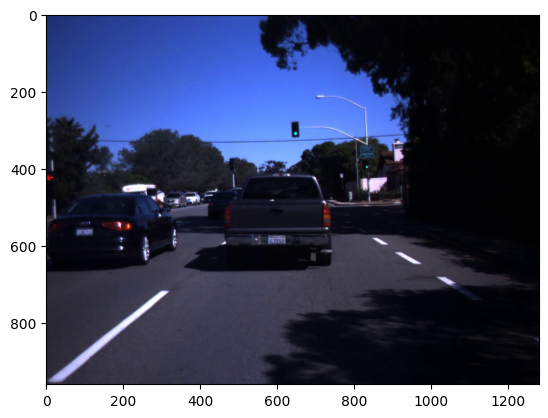

In [15]:
plt.imshow(image_np)

In [20]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tlc=TLClassifier()

Instructions for updating:
non-resource variables are not supported in the long term


In [21]:
def crop_roi_image(image_np, sel_box):
    im_height, im_width, _ = image_np.shape
    (left, right, top, bottom) = (sel_box[1] * im_width, sel_box[3] * im_width,
                                  sel_box[0] * im_height, sel_box[2] * im_height)
    cropped_image = image_np[int(top):int(bottom), int(left):int(right), :]
    return cropped_image

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.06 µs


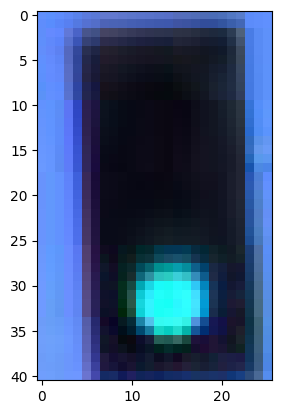

In [22]:
%time
boxes=tlc.detect_multi_object(image_np,score_threshold=0.2)
cropped_image=crop_roi_image(image_np,boxes[0])
plt.imshow(cropped_image)

# Classify the color by human intelligence

The traffic light is very "light". That is, it has high saturation values in HSV space. We can filter the high saturation area, and then classify the color by hue values.

### Convert the cropped image into HSV space

In [26]:
!pip install -U scikit-image


In [29]:
from skimage.color import rgb2hsv
hsv_test_image=rgb2hsv(cropped_image)

### Show saturation values

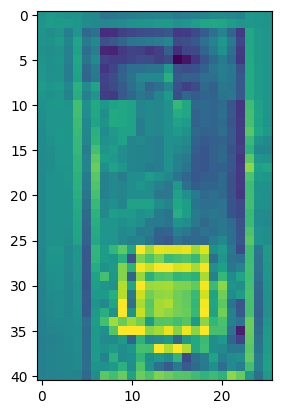

In [30]:
plt.imshow(hsv_test_image[:,:,1])

We then check the histogram to decide the filtering threshold

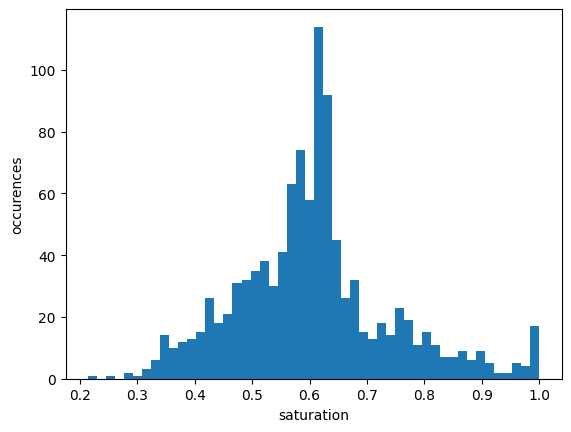

In [31]:
s_val_1d=hsv_test_image[:,:,1].ravel()
plt.hist(s_val_1d,bins=50)
plt.xlabel("saturation")
plt.ylabel("occurences")
plt.show()

### Select the high-saturation region for further classification

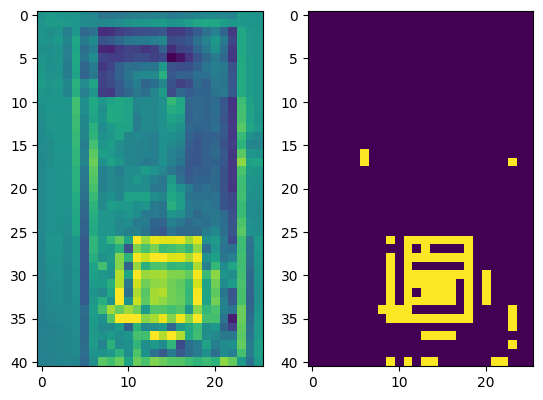

In [32]:
saturation_threshold=0.8
idx = hsv_test_image[:, :, 1] <=saturation_threshold
sat_mask = np.ones_like(hsv_test_image[:, :, 1])
sat_mask[idx] = 0
fig,ax=plt.subplots(nrows=1,ncols=2)
ax[0].imshow(hsv_test_image[:,:,1])
ax[1].imshow(sat_mask)

We perform similar operation for Value channle. This time I used my written function:

In [33]:
def high_value_region_mask(hsv_image, v_thres=0.6):
    if hsv_image.dtype == np.int:
        idx = (hsv_image[:, :, 2].astype(np.float) / 255.0) < v_thres
    else:
        idx = (hsv_image[:, :, 2].astype(np.float)) < v_thres
    mask = np.ones_like(hsv_image[:, :, 2])
    mask[idx] = 0
    return mask

<ipython-input-33-9d6922e06fa2>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if hsv_image.dtype == np.int:
<ipython-input-33-9d6922e06fa2>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = (hsv_image[:, :, 2].asty

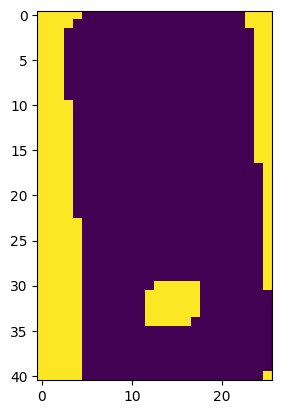

In [34]:
v_thres_val=0.9
val_mask=high_value_region_mask(hsv_test_image,v_thres=v_thres_val)
plt.imshow(val_mask)

By performing these two masks, we reach the following mask for selecting the region to calculate the average hue values

In [35]:
def get_masked_hue_image(hsv_test_image):

    s_thres_val = channel_percentile(hsv_test_image[:, :, 1], percentile=70)
    v_thres_val = channel_percentile(hsv_test_image[:, :, 2], percentile=70)
    val_mask = high_value_region_mask(hsv_test_image, v_thres=v_thres_val)
    sat_mask = high_saturation_region_mask(hsv_test_image, s_thres=s_thres_val)
    masked_hue_image = hsv_test_image[:, :, 0]
    return masked_hue_image

## Filter out the region of interest

In [36]:
def high_saturation_region_mask(hsv_image, s_thres=0.6):
    if hsv_image.dtype == np.int:
        idx = (hsv_image[:, :, 1].astype(np.float) / 255.0) < s_thres
    else:
        idx = (hsv_image[:, :, 1].astype(np.float)) < s_thres
    mask = np.ones_like(hsv_image[:, :, 1])
    mask[idx] = 0
    return mask


def channel_percentile(single_chan_image, percentile):
    sq_image = np.squeeze(single_chan_image)
    assert len(sq_image.shape) < 3

    thres_value = np.percentile(sq_image.ravel(), percentile)

    return float(thres_value) / 255.0

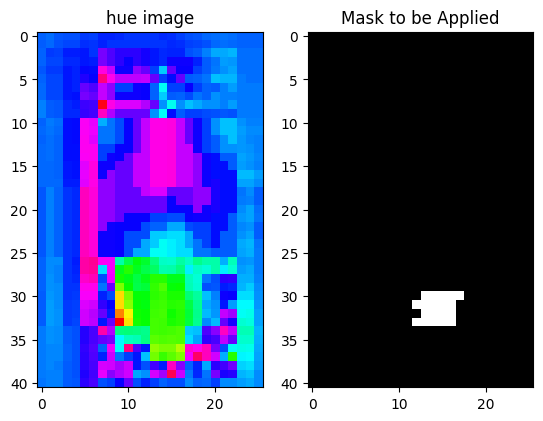

In [38]:
hue_image=hsv_test_image[:,:,0]
fig,ax=plt.subplots(nrows=1,ncols=2)
ax[0].imshow(hue_image,cmap='hsv')
ax[0].set_title("hue image")
ax[1].imshow(np.logical_and(sat_mask,val_mask))
ax[1].set_title("mask to be applied")

# Assuming you have a binary mask in sat_mask and val_mask
# You can apply the logical AND and use a colormap to visualize it
mask = np.logical_and(sat_mask, val_mask)
ax[1].imshow(mask, cmap='gray')
ax[1].set_title("Mask to be Applied")

plt.show()

Note that the following statement is not equivalent to
```
masked_hue_1d= (maksed_hue_image*np.logical_and(val_mask,sat_mask)).ravel()
```
Because zero in hue channel means red, we cannot just set unused pixels to zero.

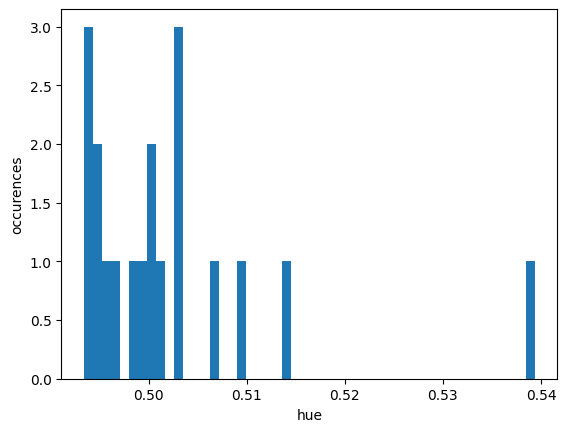

In [39]:
hue_1d=hue_image[np.logical_and(val_mask, sat_mask)].ravel()

plt.hist(hue_1d,bins=50)
plt.xlabel("hue")
plt.ylabel("occurences")
plt.show()

The hue values in this region is near 0.5, which is green.

In [40]:
def get_masked_hue_values(rgb_image):
    """
    Get the pixels in the RGB image that has high saturation (S) and value (V) in HSV chanels

    :param rgb_image: image (height, width, channel)
    :return: a 1-d array
    """

    hsv_test_image = rgb2hsv(rgb_image)
    s_thres_val = channel_percentile(hsv_test_image[:, :, 1], percentile=30)
    v_thres_val = channel_percentile(hsv_test_image[:, :, 2], percentile=70)
    val_mask = high_value_region_mask(hsv_test_image, v_thres=v_thres_val)
    sat_mask = high_saturation_region_mask(hsv_test_image, s_thres=s_thres_val)
    masked_hue_image = hsv_test_image[:, :, 0] * 180
    # Note that the following statement is not equivalent to
    # masked_hue_1d= (maksed_hue_image*np.logical_and(val_mask,sat_mask)).ravel()
    # Because zero in hue channel means red, we cannot just set unused pixels to zero.
    masked_hue_1d = masked_hue_image[np.logical_and(val_mask, sat_mask)].ravel()

    return masked_hue_1d

def convert_to_hue_angle(hue_array):
    """
    Convert the hue values from [0,179] to radian degrees [-pi, pi]

    :param hue_array: array-like, the hue values in degree [0,179]
    :return: the angles of hue values in radians [-pi, pi]
    """

    hue_cos = np.cos(hue_array * np.pi / 90)
    hue_sine = np.sin(hue_array * np.pi / 90)

    hue_angle = np.arctan2(hue_sine, hue_cos)

    return hue_angle



The following codes detects the color by hue values of an image.

In [41]:
def get_rgy_color_mask(hue_value, from_01=False):
    """
    return a tuple of np.ndarray that sets the pixels with red, green and yellow matrices to be true

    :param hue_value:
    :param from_01: True if the hue values is scaled from 0-1 (scikit-image), otherwise is -pi to pi
    :return:
    """

    if from_01:
        n_hue_value = conver_to_hue_angle_from_01(hue_value)
    else:
        n_hue_value = hue_value

    red_index = np.logical_and(n_hue_value < (0.125 * np.pi), n_hue_value > (-0.125 * np.pi))

    green_index = np.logical_and(n_hue_value > (0.66 * np.pi), n_hue_value < np.pi)

    yellow_index = np.logical_and(n_hue_value > (0.25 * np.pi), n_hue_value < (5.0 / 12.0 * np.pi))

    return red_index, green_index, yellow_index


def classify_color_by_range(hue_value):
    """
    Determine the color (red, yellow or green) in a hue value array

    :param hue_value: hue_value is radians
    :return: the color index ['red', 'yellow', 'green', '_', 'unknown']
    """

    red_index, green_index, yellow_index = get_rgy_color_mask(hue_value)

    color_counts = np.array([np.sum(red_index) / len(hue_value),
                             np.sum(yellow_index) / len(hue_value),
                             np.sum(green_index) / len(hue_value)])

    color_text = ['red', 'yellow', 'green', '_', 'unknown']

    min_index = np.argmax(color_counts)

    return min_index, color_text[min_index]

def classify_color_cropped_image(rgb_image):
    """
    Full pipeline of classifying the traffic light color from the traffic light image

    :param rgb_image: the RGB image array (height,width, RGB channel)
    :return: the color index ['red', 'yellow', 'green', '_', 'unknown']
    """

    hue_1d_deg = get_masked_hue_values(rgb_image)

    if len(hue_1d_deg) == 0:
        return 4, 'unknown'

    hue_1d_rad = convert_to_hue_angle(hue_1d_deg)

    return classify_color_by_range(hue_1d_rad)

In [42]:
classify_color_cropped_image(cropped_image)

<ipython-input-33-9d6922e06fa2>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if hsv_image.dtype == np.int:
<ipython-input-33-9d6922e06fa2>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = (hsv_image[:, :, 2].asty

(2, 'green')

# Put all things together to classify an image

In [43]:
boxes=tlc.detect_multi_object(image_np,score_threshold=0.1)

In [44]:
def classify_all_boxes_in_image(image_np, boxes):
    result_index_array = np.zeros(boxes.shape[0], dtype=np.int)
    for i, box in enumerate(boxes):
        cropped_image = crop_roi_image(image_np, box)
        result_color_index, _ = classify_color_cropped_image(cropped_image)
        result_index_array[i] = result_color_index

    return result_index_array

In [45]:
results_index=classify_all_boxes_in_image(image_np,boxes)

<ipython-input-44-b59367bcd8b9>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  result_index_array = np.zeros(boxes.shape[0], dtype=np.int)
<ipython-input-33-9d6922e06fa2>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

The following function labels the traffic lights. The color of frames correspond to the traffic light colors.

In [46]:
# Visulaization utils


# Some of the functions:
# vis_util.draw_bounding_box_on_image_array
# vis_util.draw_bounding_box_on_image
# vis_util.draw_bounding_boxes_on_image_array
# vis_util.draw_bounding_boxes_on_image
# are copied from
# https://github.com/tensorflow/models/blob/fe748d4a4a1576b57c279014ac0ceb47344399c4/research/object_detection/utils/visualization_utils.py
# Copyright 2017 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================



import numpy as np
#from object_detection.utils import visualization_utils as vis_util
import matplotlib.pyplot as plt

import PIL.Image as Image
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont

# color maps for drawing the resulting identified traffic light color on the image.
COLOR_MAP = ['#f44141',  # red,
             '#f1f441',  # yellow
             '#a7f442',  # green
             '#ffffff',  # white
             '#ffffff',  # white
             ]


def draw_bounding_box_on_image_array(image,
                                     ymin,
                                     xmin,
                                     ymax,
                                     xmax,
                                     color='red',
                                     thickness=4,
                                     display_str_list=(),
                                     use_normalized_coordinates=True):
    """Adds a bounding box to an image (numpy array).

    Bounding box coordinates can be specified in either absolute (pixel) or
    normalized coordinates by setting the use_normalized_coordinates argument.

    Args:
      image: a numpy array with shape [height, width, 3].
      ymin: ymin of bounding box.
      xmin: xmin of bounding box.
      ymax: ymax of bounding box.
      xmax: xmax of bounding box.
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
      display_str_list: list of strings to display in box
                        (each to be shown on its own line).
      use_normalized_coordinates: If True (default), treat coordinates
        ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
        coordinates as absolute.
    """
    image_pil = Image.fromarray(np.uint8(image)).convert('RGB')
    draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color,
                               thickness, display_str_list,
                               use_normalized_coordinates)
    np.copyto(image, np.array(image_pil))


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color='red',
                               thickness=4,
                               display_str_list=(),
                               use_normalized_coordinates=True):
    """Adds a bounding box to an image.

    Bounding box coordinates can be specified in either absolute (pixel) or
    normalized coordinates by setting the use_normalized_coordinates argument.

    Each string in display_str_list is displayed on a separate line above the
    bounding box in black text on a rectangle filled with the input 'color'.
    If the top of the bounding box extends to the edge of the image, the strings
    are displayed below the bounding box.

    Args:
      image: a PIL.Image object.
      ymin: ymin of bounding box.
      xmin: xmin of bounding box.
      ymax: ymax of bounding box.
      xmax: xmax of bounding box.
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
      display_str_list: list of strings to display in box
                        (each to be shown on its own line).
      use_normalized_coordinates: If True (default), treat coordinates
        ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
        coordinates as absolute.
    """
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    if use_normalized_coordinates:
        (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                      ymin * im_height, ymax * im_height)
    else:
        (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
    draw.line([(left, top), (left, bottom), (right, bottom),
               (right, top), (left, top)], width=thickness, fill=color)
    try:
        font = ImageFont.truetype('arial.ttf', 24)
    except IOError:
        font = ImageFont.load_default()

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle(
            [(left, text_bottom - text_height - 2 * margin), (left + text_width,
                                                              text_bottom)],
            fill=color)
        draw.text(
            (left + margin, text_bottom - text_height - margin),
            display_str,
            fill='black',
            font=font)
        text_bottom -= text_height - 2 * margin


def draw_bounding_boxes_on_image_array(image,
                                       boxes,
                                       color='red',
                                       thickness=4,
                                       display_str_list_list=()):
    """Draws bounding boxes on image (numpy array).

    Args:
      image: a numpy array object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
      display_str_list_list: list of list of strings.
                             a list of strings for each bounding box.
                             The reason to pass a list of strings for a
                             bounding box is that it might contain
                             multiple labels.

    Raises:
      ValueError: if boxes is not a [N, 4] array
    """
    image_pil = Image.fromarray(image)
    draw_bounding_boxes_on_image(image_pil, boxes, color, thickness,
                                 display_str_list_list)
    np.copyto(image, np.array(image_pil))


def draw_bounding_boxes_on_image(image,
                                 boxes,
                                 color='red',
                                 thickness=4,
                                 display_str_list_list=()):
    """Draws bounding boxes on image.

    Args:
      image: a PIL.Image object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
      display_str_list_list: list of list of strings.
                             a list of strings for each bounding box.
                             The reason to pass a list of strings for a
                             bounding box is that it might contain
                             multiple labels.

    Raises:
      ValueError: if boxes is not a [N, 4] array
    """
    boxes_shape = boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError('Input must be of size [N, 4]')
    for i in range(boxes_shape[0]):
        display_str_list = ()
        if display_str_list_list:
            display_str_list = display_str_list_list[i]
        draw_bounding_box_on_image(image, boxes[i, 0], boxes[i, 1], boxes[i, 2],
                                   boxes[i, 3], color, thickness, display_str_list)

def draw_result_on_image(image_np, box, tl_result):
    """
    Draw color box based on the calssifed traffic light results
    :param image_np: the image to draw on
    :param box: the normalized box index
    :param tl_result: the index returned by classify_color_v2()
    :return:
    """
    ymin, xmin, ymax, xmax = box
    color = COLOR_MAP[tl_result]
    draw_bounding_box_on_image_array(image_np, ymin, xmin, ymax, xmax, color=color)
    return image_np

In [47]:
def draw_results_on_image(image_np, boxes, tl_results_array):
    for i, box in enumerate(boxes):
        draw_result_on_image(image_np, box, tl_results_array[i])

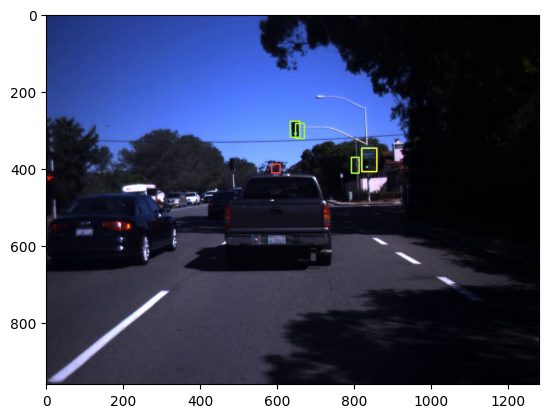

In [48]:
n_image_np=np.copy(image_np)
draw_results_on_image(n_image_np, boxes, results_index)
plt.imshow(n_image_np)

# Further work
In this work I just some algorithmic way to classify the traffic light color. But this may be replaced by using the training the a machine learning model to do this. An alternative is training this CNN pretrained model to classify the traffic lights.